In [12]:
import astropy
from astropy.io import fits
import numpy as np
from numpy import *
%matplotlib inline
import matplotlib.pyplot as plt
from  matplotlib.pyplot import *
import eazy
import os
import grizli

OSError: /Users/rsimons/grizli/templates/fsps/fsps_QSF_12_v3_nolines_001.dat not found.

In [8]:
def readEazyBinary(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY='./OUTPUT', CACHE_FILE='Same'):

    """
    Author: Gabe Brammer
    This function has been clipped from eazyPy.py in thethreedhst git respository
    https://github.com/gbrammer/threedhst/tree/master/threedhst

    tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE='photz', \
                                                OUTPUT_DIRECTORY='./OUTPUT', \
                                                CACHE_FILE = 'Same')

    Read Eazy BINARY_OUTPUTS files into structure data.
    
    If the BINARY_OUTPUTS files are not in './OUTPUT', provide either a relative or absolute path
    in the OUTPUT_DIRECTORY keyword.
    
    By default assumes that CACHE_FILE is MAIN_OUTPUT_FILE+'.tempfilt'.
    Specify the full filename if otherwise. 
    """
    
    #root='COSMOS/OUTPUT/cat3.4_default_lines_zp33sspNoU'
    
    root = OUTPUT_DIRECTORY+'/'+MAIN_OUTPUT_FILE
    
    ###### .tempfilt
    if CACHE_FILE == 'Same':
        CACHE_FILE = root+'.tempfilt'
    
    if os.path.exists(CACHE_FILE) is False:
        print(('File, %s, not found.' %(CACHE_FILE)))
        return -1,-1,-1,-1
    
    f = open(CACHE_FILE,'rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    tempfilt = np.fromfile(file=f,dtype=np.double,count=NFILT*NTEMP*NZ).reshape((NZ,NTEMP,NFILT)).transpose()
    lc = np.fromfile(file=f,dtype=np.double,count=NFILT)
    zgrid = np.fromfile(file=f,dtype=np.double,count=NZ)
    fnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    efnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    
    f.close()
    
    tempfilt  = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
                 'tempfilt':tempfilt,'lc':lc,'zgrid':zgrid,'fnu':fnu,'efnu':efnu}
    
    ###### .coeff
    f = open(root+'.coeff','rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    coeffs = np.fromfile(file=f,dtype=np.double,count=NTEMP*NOBJ).reshape((NOBJ,NTEMP)).transpose()
    izbest = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
    tnorm = np.fromfile(file=f,dtype=np.double,count=NTEMP)
    
    f.close()
    
    coeffs = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
              'coeffs':coeffs,'izbest':izbest,'tnorm':tnorm}
              
    ###### .temp_sed
    f = open(root+'.temp_sed','rb')
    s = np.fromfile(file=f,dtype=np.int32, count=3)
    NTEMP=s[0]
    NTEMPL=s[1]
    NZ=s[2]
    templam = np.fromfile(file=f,dtype=np.double,count=NTEMPL)
    temp_seds = np.fromfile(file=f,dtype=np.double,count=NTEMPL*NTEMP).reshape((NTEMP,NTEMPL)).transpose()
    da = np.fromfile(file=f,dtype=np.double,count=NZ)
    db = np.fromfile(file=f,dtype=np.double,count=NZ)
    
    f.close()
    
    temp_sed = {'NTEMP':NTEMP,'NTEMPL':NTEMPL,'NZ':NZ,\
              'templam':templam,'temp_seds':temp_seds,'da':da,'db':db}
              
    ###### .pz
    if os.path.exists(root+'.pz'):
        f = open(root+'.pz','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=2)
        NZ=s[0]
        NOBJ=s[1]
        chi2fit = np.fromfile(file=f,dtype=np.double,count=NZ*NOBJ).reshape((NOBJ,NZ)).transpose()

        ### This will break if APPLY_PRIOR No
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        
        if len(s) > 0:
            NK = s[0]
            kbins = np.fromfile(file=f,dtype=np.double,count=NK)
            priorzk = np.fromfile(file=f, dtype=np.double, count=NZ*NK).reshape((NK,NZ)).transpose()
            kidx = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
            pz = {'NZ':NZ,'NOBJ':NOBJ,'NK':NK, 'chi2fit':chi2fit, 'kbins':kbins, 'priorzk':priorzk,'kidx':kidx}
        else:
            pz = None
        
        f.close()
        
    else:
        pz = None
    
    if False:
        f = open(root+'.zbin','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        NOBJ=s[0]
        z_a = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_p = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m1 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m2 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_peak = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        f.close()
        
    ###### Done.    
    return tempfilt, coeffs, temp_sed, pz



In [14]:
PATH_TO_CATS = '/Users/rsimons/Desktop/clear/Catalogs'

tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE='goodss_3dhst.v4.3', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
params = {}
#self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodss', 'v4.3')
params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cat'.format('goodsn', 'v4.3')
params['Z_STEP'] = 0.002
params['Z_MAX'] = 4
params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodss', 'v4.3')
params['PRIOR_FILTER'] = 205
translate_file = PATH_TO_CATS + '/{0}_{1}.translate'.format('goodss', 'v4.3')




#gdn_cat = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/goodsn_3dhst.v4.3.cat')
#gds_cat = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.3.cat')
#gdn_nzpcat = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/goodsn_3dhst.v4.3.nzpcat')
#gds_nzpcat = np.loadtxt('/Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.3.nzpcat')




File, /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.3.tempfilt, not found.


KeyboardInterrupt: 

In [19]:
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, 
                        zeropoint_file=None, params=params, 
                        load_prior=True, load_products=False)

ep = photoz.EazyPhot(ez)

Read default param file: /anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/zphot.param.default


FileNotFoundError: [Errno 2] No such file or directory: 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

In [11]:
ra = 189.227651
dec = 62.190866
phot, ii, dd = ep.get_phot_dict(ra, dec)


NameError: name 'ep' is not defined

In [14]:
colnames = 'id x y ra dec faper_F160W eaper_F160W faper_F140W eaper_F140W f_F160W e_F160W w_F160W f_U e_U w_U f_F435W e_F435W w_F435W f_B e_B w_B f_G e_G w_G f_V e_V w_V f_F606W e_F606W w_F606W f_R e_R w_R f_Rs e_Rs w_Rs f_I e_I w_I f_F775W e_F775W w_F775W f_Z e_Z w_Z f_F850LP e_F850LP w_F850LP f_F105W e_F105W w_F105W f_F125W e_F125W w_F125W f_J e_J w_J f_F140W e_F140W w_F140W f_H e_H w_H f_Ks e_Ks w_Ks f_IRAC1 e_IRAC1 w_IRAC1 f_IRAC2 e_IRAC2 w_IRAC2 f_IRAC3 e_IRAC3 w_IRAC3 f_IRAC4 e_IRAC4 w_IRAC4 tot_cor wmin_ground wmin_hst wmin_wfc3 wmin_irac z_spec star_flag kron_radius a_image b_image theta_J2000 class_star flux_radius fwhm_image flags IRAC1_contam IRAC2_contam IRAC3_contam IRAC4_contam contam_flag f140w_flag use'.split(' ')

In [29]:
colnames = array(colnames)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


(-5, 5)

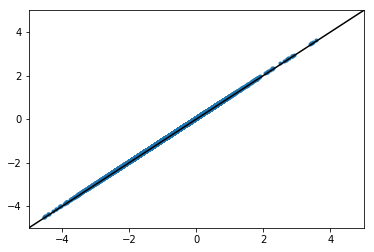

In [46]:
band = 'f_U'

f_z = gdn_cat[:,np.where(colnames == band)[0]]
f_z_npz = gdn_nzpcat[:,np.where(colnames == band)[0]]




plot(log10(f_z), log10(f_z_npz), '.')
plot([-10, 10], [-10, 10], 'k-')
xlim(-5, 5)
ylim(-5,5)

In [8]:
ids

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 3.8277e+04, 3.8278e+04,
       3.8279e+04])